In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_201901010000_201912312359_Stunde.xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11833
1,0.10008
2,0.08593
3,0.08010
4,0.08260


In [56]:

def settings_to_target_df(pricing_type, operation_type, feed_in_type,grid_charge_type, grid_charging_allowed,hp=False,ev=False,costs=False):
    target_df = pd.read_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    if hp:
        target_df = pd.read_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}new.pkl")
    elif ev:
        target_df = pd.read_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}new.pkl")
    
    elif costs:
        target_df = pd.read_pickle(f"./output/detailed_financials/Costs_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}new.pkl")

    return target_df



In [57]:
def calculate_peaks_based_on_case(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    target_df = target_df[["Sum"]]
    heat_pump_peak_day = '2019-12-01'
    pv_peak_day = '2019-05-13'
    pv_peak = target_df["Sum"][pv_peak_day].abs().max()
    heat_pump_peak_day = '2019-12-01'
    hp_peak = target_df["Sum"][heat_pump_peak_day].abs().max()
    ev_peak_day = "2019-01-05"
    ev_peak = target_df["Sum"][ev_peak_day].abs().max()
    total_peak = target_df["Sum"].abs().max()
    
    case["worst_hp_day_peak_load"] = hp_peak
    case["worst_pv_day_peak_load"] = pv_peak
    case["worst_ev_day_peak_load"] = ev_peak
    case["worst_total_peak_load"] = total_peak
    
def calculate_agg_hp_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_hp_consumption = target_df["Sum"].sum()
    case["yearly_hp_consumption"] = total_hp_consumption
    
def calculate_agg_ev_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_ev_consumption = target_df["Sum"].sum()
    case["yearly_ev_consumption"] = total_ev_consumption

In [58]:
case_constant_without_flexibility = {"name":"Constant Volumetric_FIT without flexiblity","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "constant","grid_charging_allowed":"False"}



case_volumetric_fit_gcfalse_constant = {"name":"Constant Volumetric_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_fit_gcfalse = {"name":"Dynamic Volumetric_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_volumetric_dynamic_gcfalse_constant = {"name":"Constant Volumetric_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_dynamic_gcfalse = {"name":"Dynamic Volumetric_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_peak_fit_gcfalse_constant = {"name":"Constant Peak_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gcfalse = {"name":"Dynamic Peak_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_peak_dynamic_gcfalse_constant = {"name":"Constant Peak_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_dynamic_gcfalse = {"name":"Dynamic Peak_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_rotating_fit_gcfalse_constant = {"name":"Constant Rotating_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "rotating", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_rotating_fit_gcfalse = {"name":"Dynamic Rotating_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "rotating", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_rotating_dynamic_gcfalse_constant = {"name":"Constant Rotating_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "rotating", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_rotating_dynamic_gcfalse = {"name":"Dynamic Rotating_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "rotating", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_segmented_fit_gcfalse_constant = {"name":"Constant Segmented_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "segmented", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_segmented_fit_gcfalse = {"name":"Dynamic Segmented_FIT","feed_in_tariff" :"fit", "grid_charge_type" : "segmented", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}

case_segmented_dynamic_gcfalse_constant = {"name":"Constant Segmented_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "segmented", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_segmented_dynamic_gcfalse = {"name":"Dynamic Segmented_DynFeed","feed_in_tariff" :"dynamic", "grid_charge_type" : "segmented", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}




cases = [
    case_constant_without_flexibility,
    case_volumetric_fit_gcfalse_constant,
    case_volumetric_fit_gcfalse,
    case_volumetric_dynamic_gcfalse_constant,
    case_volumetric_dynamic_gcfalse,
    case_peak_fit_gcfalse_constant,
    case_peak_fit_gcfalse,
    case_peak_dynamic_gcfalse_constant,
    case_peak_dynamic_gcfalse,
    case_rotating_fit_gcfalse_constant,
    case_rotating_fit_gcfalse,
    case_rotating_dynamic_gcfalse_constant,
    case_rotating_dynamic_gcfalse,
    case_segmented_fit_gcfalse_constant,
    case_segmented_fit_gcfalse,
    case_segmented_dynamic_gcfalse_constant,
    case_segmented_dynamic_gcfalse
]


for case in cases: 
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    
    calculate_peaks_based_on_case(target_df_consumption, case)
    #target_df_hp = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
    #                                                 case["grid_charging_allowed"],hp=True)
    
    #calculate_agg_hp_consumption(target_df_hp,case)
    
    #target_df_ev = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
    #                                                 case["grid_charging_allowed"],ev=True)
    
    #calculate_agg_ev_consumption(target_df_ev,case)


In [59]:
cases_comparison = pd.DataFrame(cases).set_index("name")
cases_comparison

,feed_in_tariff,grid_charge_type,pricing_type,operation_type,grid_charging_allowed,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load
name,,,,,,,,,
Constant Volumetric_FIT without flexiblity,fit,volumetric,constant,constant,False,1189.895552,1969.291920,850.291443,2272.280106
Constant Volumetric_FIT,fit,volumetric,constant,dynamic,False,1179.738184,1865.716547,804.351724,2270.215044
Dynamic Volumetric_FIT,fit,volumetric,dynamic,dynamic,False,2258.863187,1891.809271,1808.283645,2788.421902
Constant Volumetric_DynFeed,dynamic,volumetric,constant,dynamic,False,1202.097625,2189.008131,803.849606,2496.459234
Dynamic Volumetric_DynFeed,dynamic,volumetric,dynamic,dynamic,False,2257.120418,2159.036181,1805.607559,2787.834156
Constant Peak_FIT,fit,peak,constant,dynamic,False,996.379477,1892.497239,714.862949,2267.087738
Dynamic Peak_FIT,fit,peak,dynamic,dynamic,False,1693.579448,1944.104045,1393.246474,2560.053934
Constant Peak_DynFeed,dynamic,peak,constant,dynamic,False,1204.518529,2597.758309,739.615017,2652.335066
Dynamic Peak_DynFeed,dynamic,peak,dynamic,dynamic,False,1699.558072,2512.484654,1389.712411,2650.297716


In [70]:
paper_case_overview = cases_comparison.copy()
paper_case_overview = paper_case_overview[["feed_in_tariff","grid_charge_type","pricing_type","operation_type"]]
paper_case_overview = paper_case_overview.rename({"feed_in_tariff":"FIT","grid_charge_type":"Grid Charges","pricing_type":"Electricity Tariff","operation_type":"Operation" 
                           },axis=1)
paper_case_overview.to_latex("./output/case_overview.tex")

<ipython-input-70-af1347a3b3b1>:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  paper_case_overview.to_latex("./output/case_overview.tex")


In [72]:
paper_case_results = cases_comparison.drop(["feed_in_tariff","grid_charge_type","pricing_type","operation_type","grid_charging_allowed"],axis=1).round(1)
paper_case_results = paper_case_results.rename({"worst_hp_day_peak_load":"Heat pump peak [kW]","worst_pv_day_peak_load":"Feed-in peak [kW]","worst_ev_day_peak_load":"EV peak [kW]","worst_total_peak_load":"Yearly peak [kW]"},axis=1)
paper_case_results.to_latex("./output/case_peaks.tex")


<ipython-input-72-2f2161b87cad>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  paper_case_results.to_latex("./output/case_peaks.tex")


In [13]:
cases_comparison[["worst_hp_day_peak_load","worst_pv_day_peak_load","worst_ev_day_peak_load","worst_total_peak_load"]].style.background_gradient(cmap='RdYlGn_r')

,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load
name,,,,
Constant Volumetric_FIT,1179.738184,1865.716547,804.351724,2270.215044
Dynamic Volumetric_FIT,2258.863187,1891.809271,1808.283645,2788.421902
Constant Volumetric_DynFeed,1202.097625,2189.008131,803.849606,2496.459234
Dynamic Volumetric_DynFeed,2257.120418,2159.036181,1805.607559,2787.834156
Constant Peak_FIT,996.379477,1892.497239,714.862949,2267.087738
Dynamic Peak_FIT,1693.579448,1944.104045,1393.246474,2560.053934
Constant Peak_DynFeed,1204.518529,2597.758309,739.615017,2652.335066
Dynamic Peak_DynFeed,1699.558072,2512.484654,1389.712411,2650.297716
Constant Rotating_FIT,1227.637986,1876.052445,831.266498,2246.771169


In [ ]:
'''cases_comparison[["yearly_hp_consumption"]].style.background_gradient(cmap='RdYlGn_r')

'''

In [ ]:
'''cases_comparison[["yearly_ev_consumption"]].style.background_gradient(cmap='RdYlGn_r')

'''

# Comparing load patterns

In the following, we compare resulting aggregated load patterns by policies.

In [14]:
compare_df = pd.DataFrame()


for case in cases:
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    compare_df[case["name"]] = target_df_consumption.sum(axis=1)
    compare_df.index = target_df_consumption.index
    
compare_df["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].values
compare_df.index = compare_df.index.strftime('%Y-%m-%d %H:%M:%S')


<ipython-input-15-f00466d8edc9>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


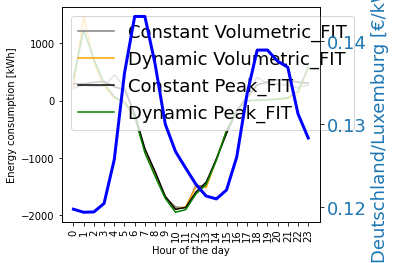

In [15]:
day = 132

fig, ax1 = plt.subplots()

plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (18,12)


color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy consumption [kWh]', color="black")
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Volumetric_FIT'].iloc[day*24:(day+1)*24], color="grey", label='Constant Volumetric_FIT')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Volumetric_FIT'].iloc[day*24:(day+1)*24], color="orange", label='Dynamic Volumetric_FIT')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Peak_FIT'].iloc[day*24:(day+1)*24], color="black", label='Constant Peak_FIT')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Peak_FIT'].iloc[day*24:(day+1)*24], color="green", label='Dynamic Peak_FIT')
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(compare_df.index[day*24:(day+1)*24], compare_df['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24],lw=3,color="blue")
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


fig.tight_layout()  # for a neat layout
plt.show()



In [16]:
### Comparing costs 
###### TODO: ROTATING NUMBERS ARE WRONG, STILL HAS TO BE IMPLEMENTED

costs = []

for case in cases:
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])

    # creating two data
    df_consumption = target_df_consumption.copy()
    df_feedin = target_df_consumption.copy()
    df_consumption[df_consumption < 0] = 0
    df_feedin[df_feedin > 0] = 0
    df_feedin = df_feedin.abs()
    
    if case["grid_charge_type"] == "volumetric":
        total_costs_grid = df_consumption.sum().sum()*0.0722
    elif case["grid_charge_type"] == "peak":
        total_costs_grid = df_consumption.max()*67.94
        total_costs_grid = total_costs_grid.sum()
        
    if case["pricing_type"]=="constant":
        total_costs_energy = df_consumption.sum()*(df_p.mean()[0])
        total_costs_energy = total_costs_energy.sum()
        pass
    elif case["pricing_type"]=="dynamic":
        total_costs_energy = (df_consumption.values*df_p.values).sum()
        
    if case["feed_in_tariff"] == "fit":
        total_feed_in_profits = ((df_feedin.sum()*(0.0722))).sum()
    elif case["feed_in_tariff"] == "dynamic":
        total_feed_in_profits = ((df_feedin.values*df_p.values)).sum()
    
    cost_case = {"name":case["name"],"Grid Costs":total_costs_grid,"Energy Costs":total_costs_energy,"Feed In Compensation":total_feed_in_profits,"Total Costs":total_costs_energy+total_costs_grid-total_feed_in_profits}
    costs.append(cost_case)

<Axes: xlabel='name'>

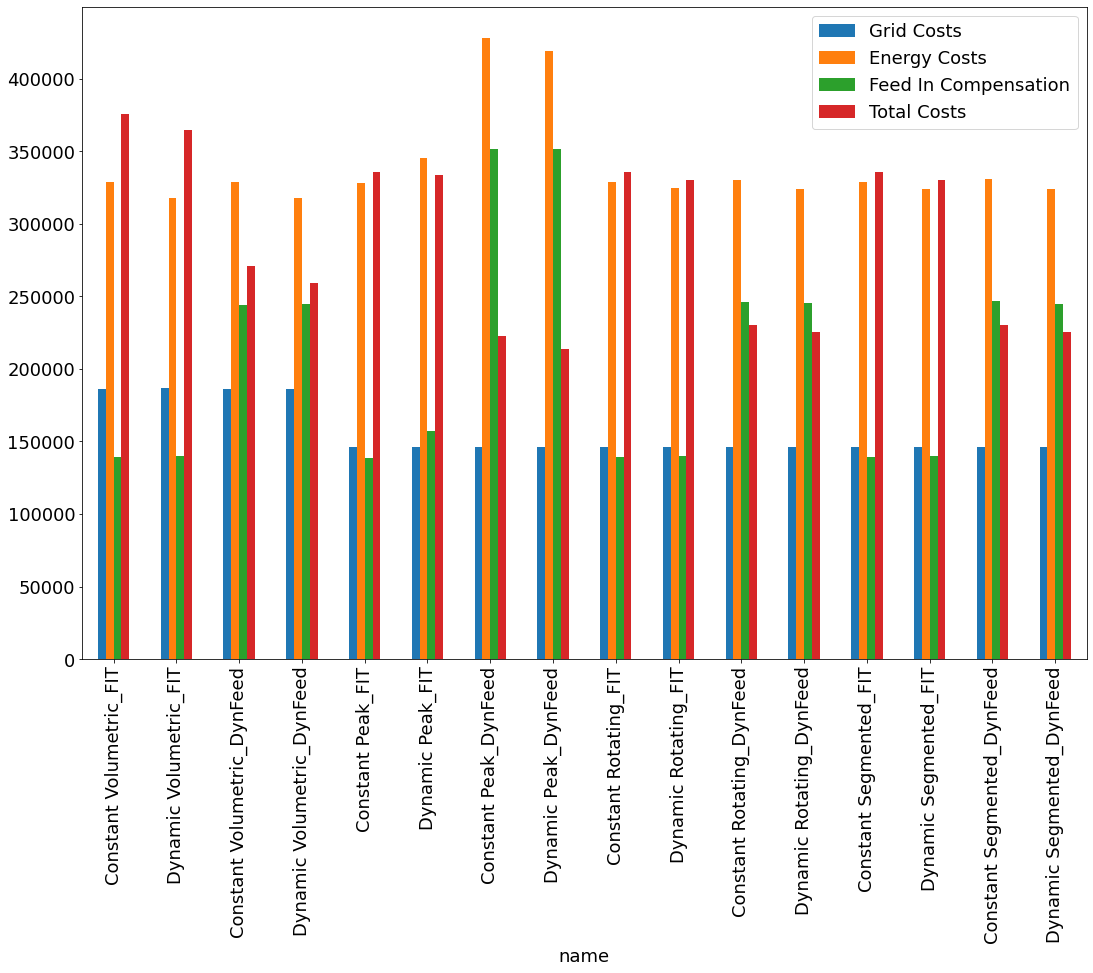

In [17]:
pd.DataFrame(costs).set_index("name").plot.bar()

# Calculate Ramp-Ups

In this section, we analyze the ramp-up from constant to dynamic tariffs and the effects on peak loads.

volumetric fit


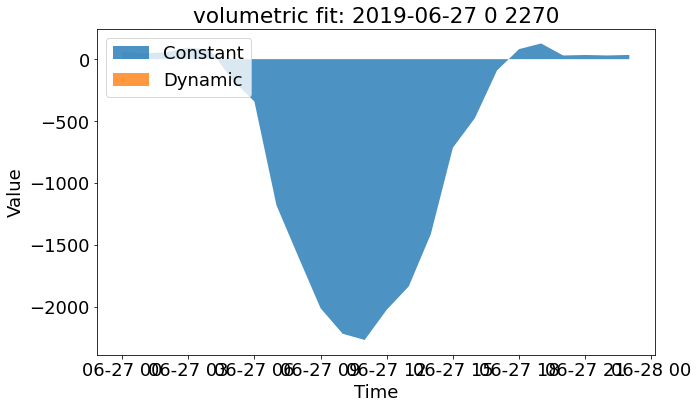

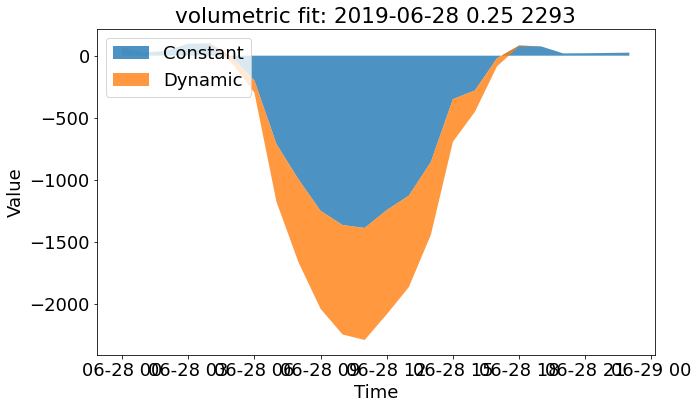

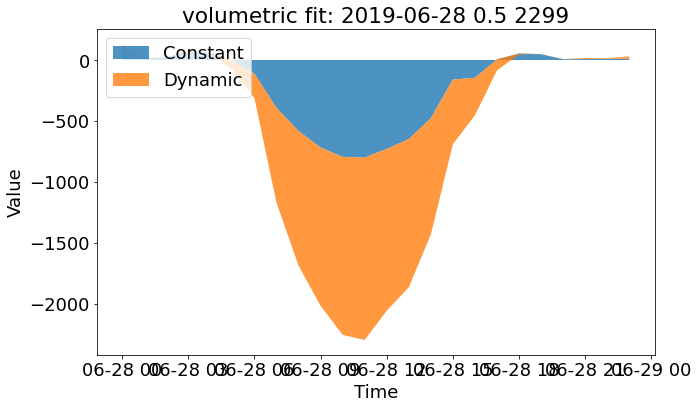

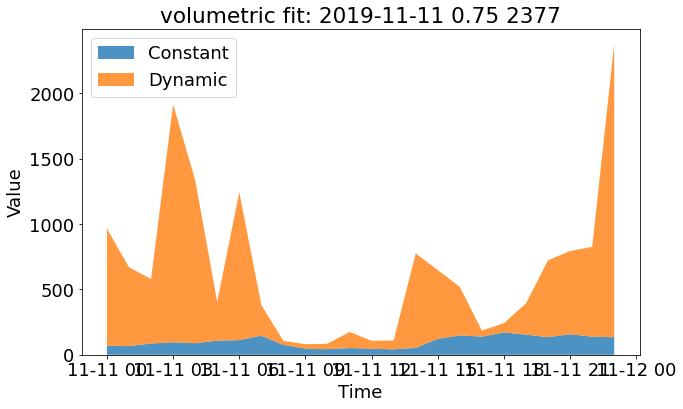

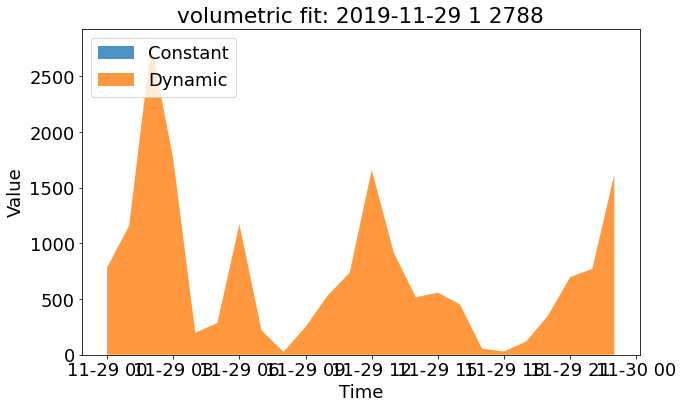

volumetric dynamic


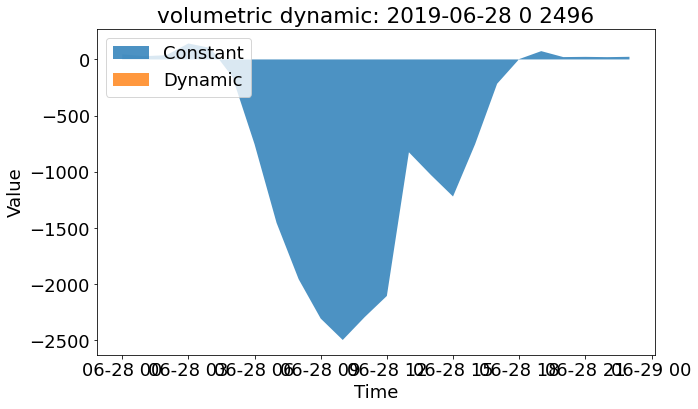

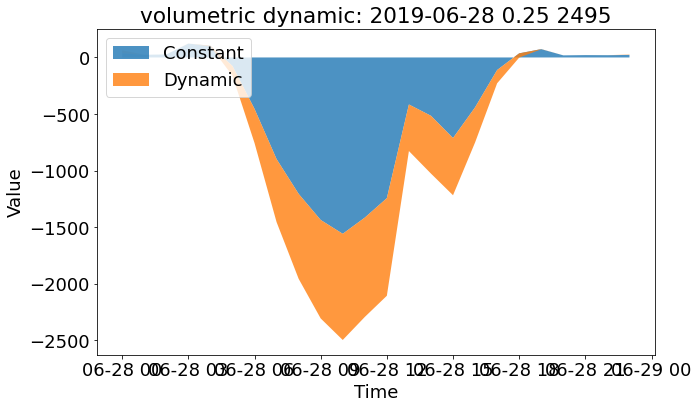

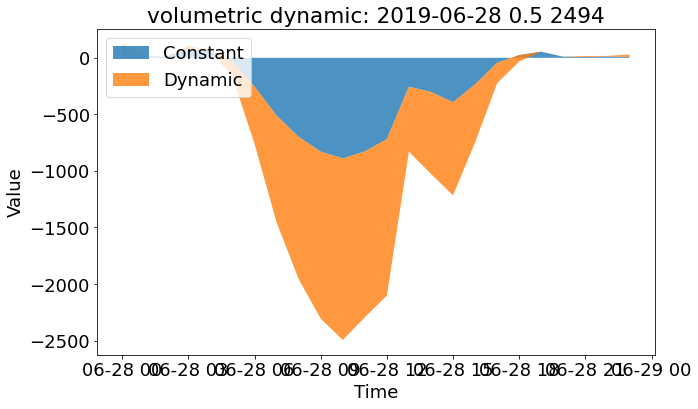

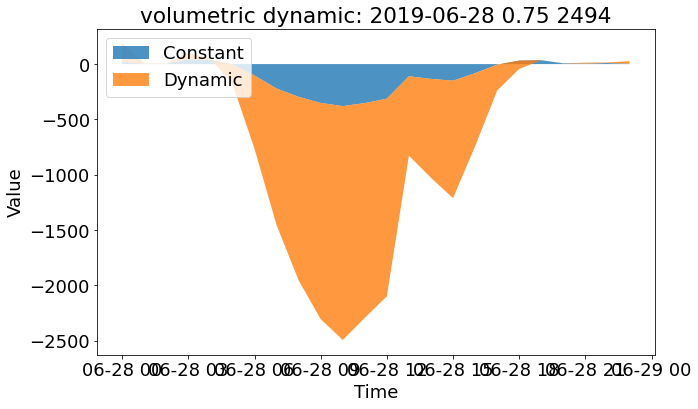

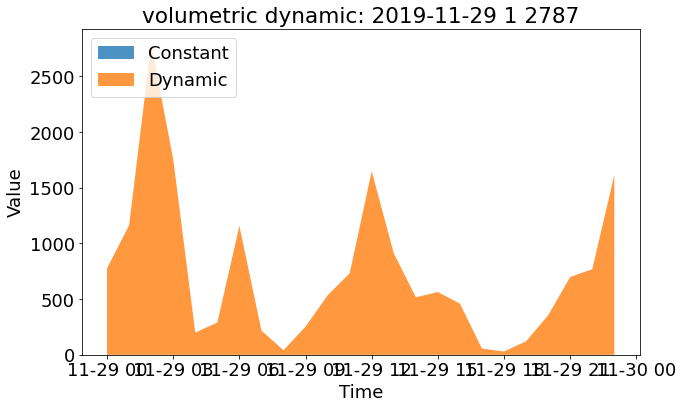

peak fit


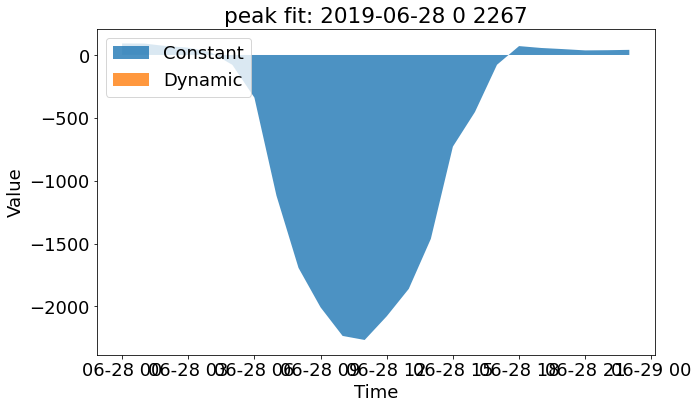

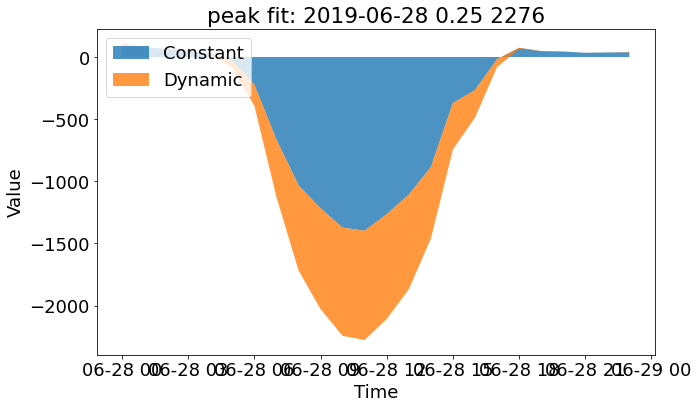

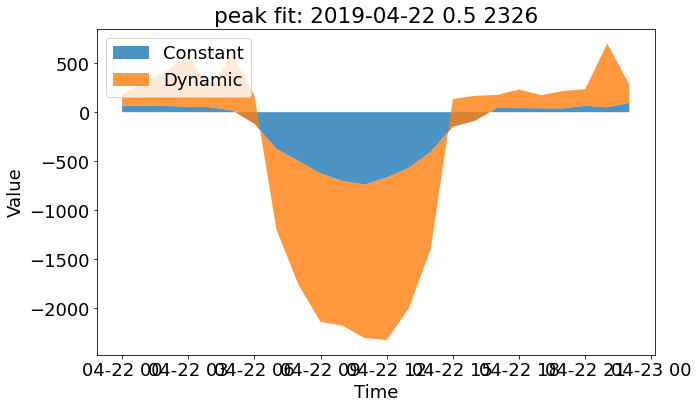

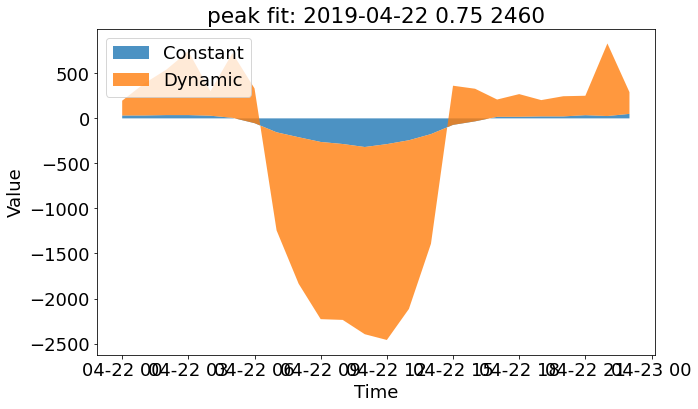

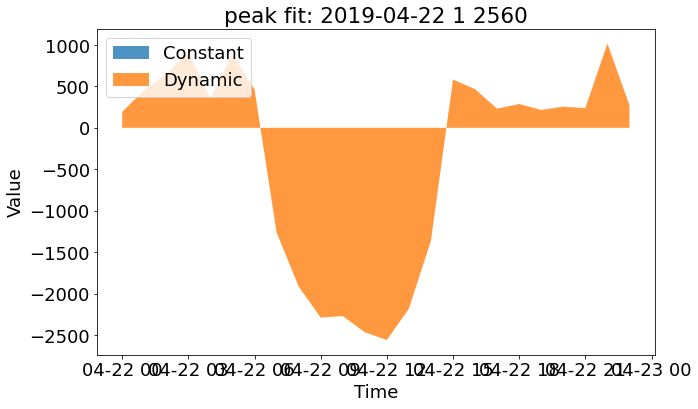

peak dynamic


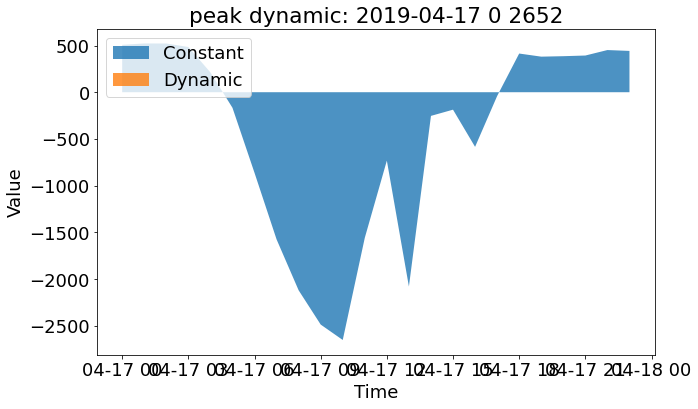

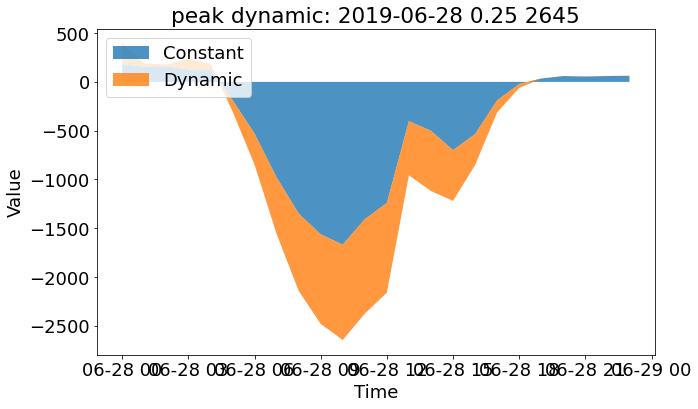

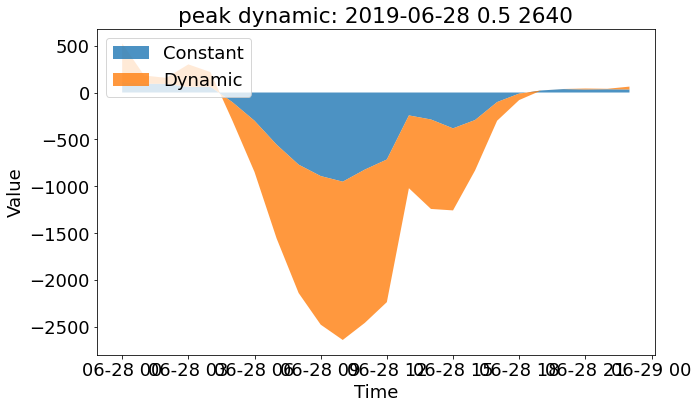

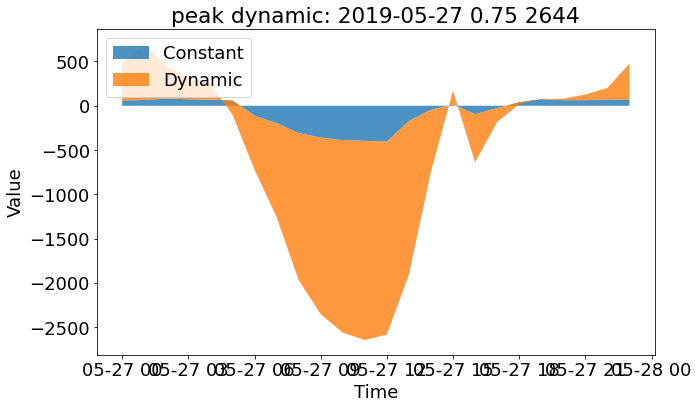

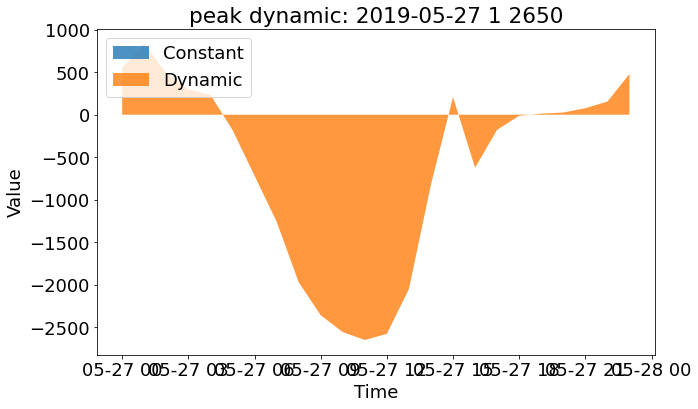

rotating fit


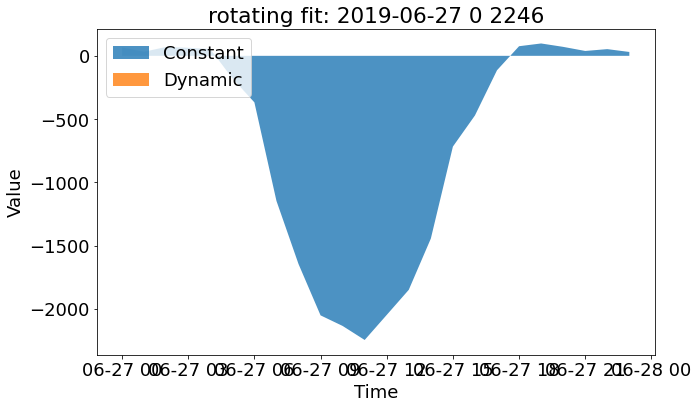

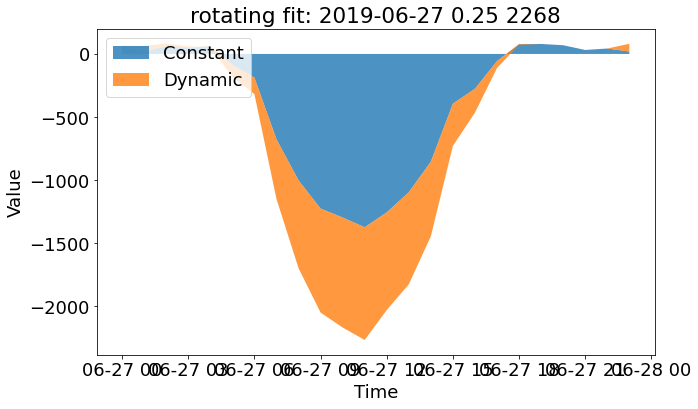

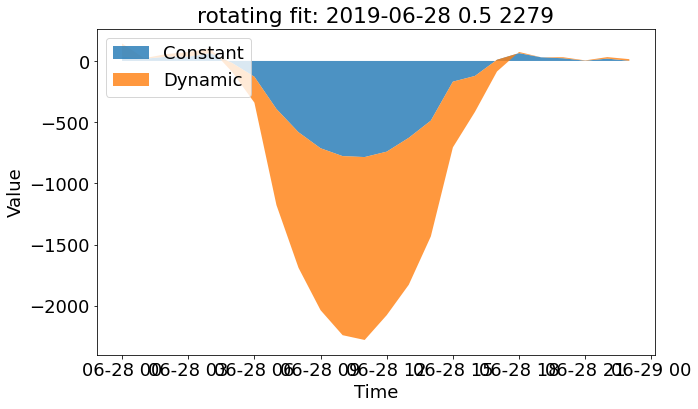

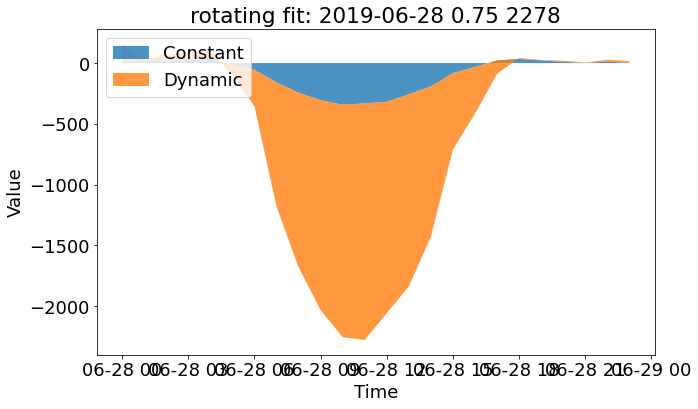

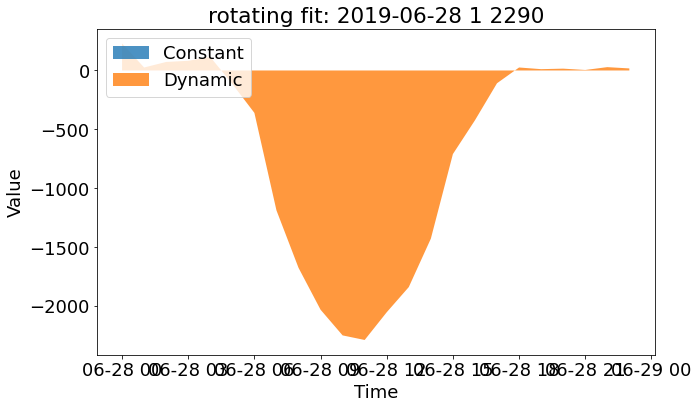

rotating dynamic


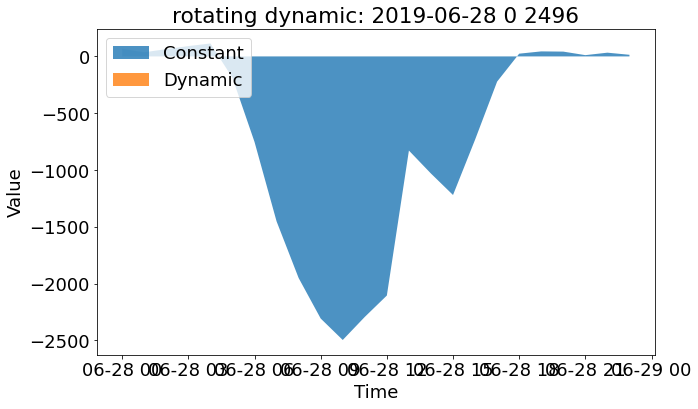

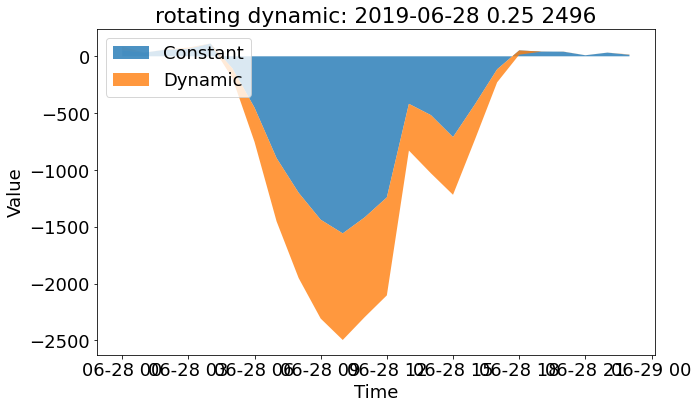

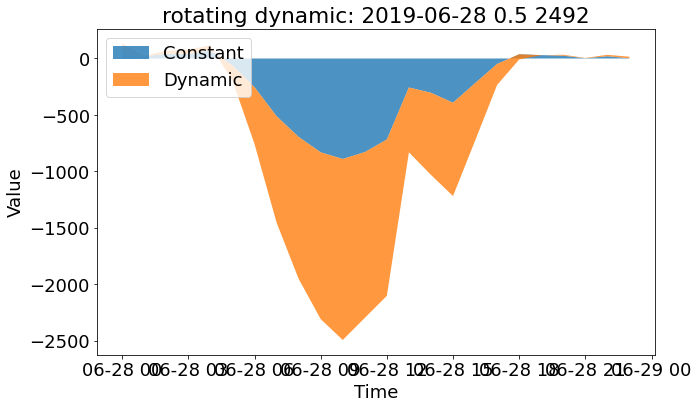

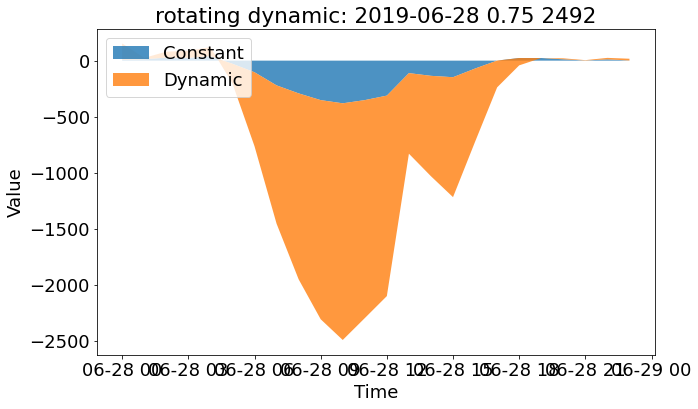

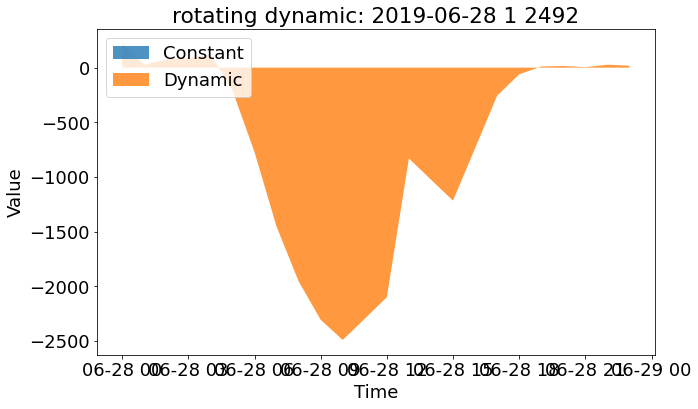

segmented fit


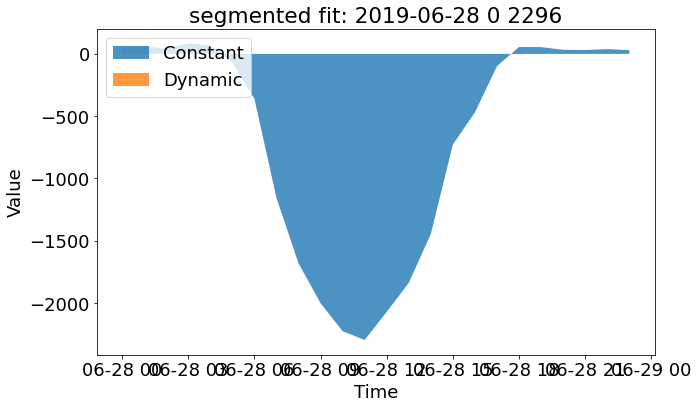

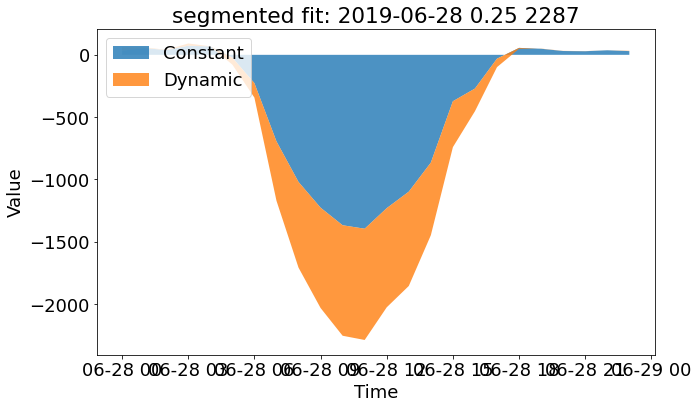

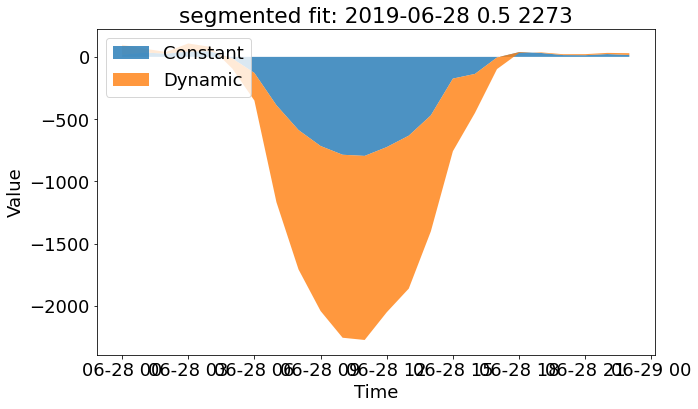

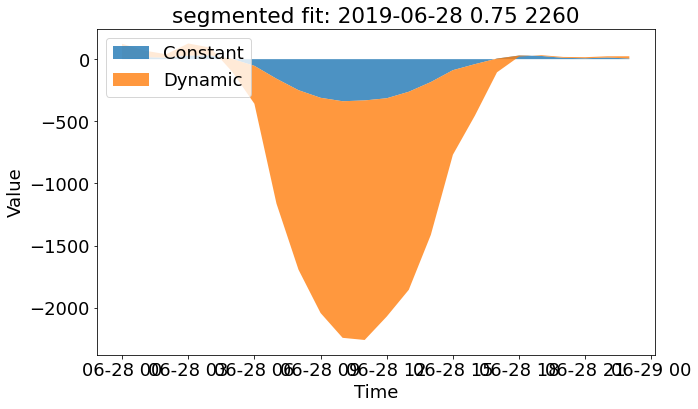

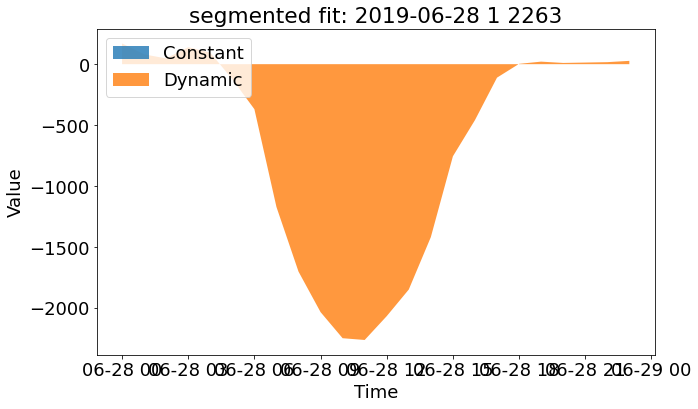

segmented dynamic


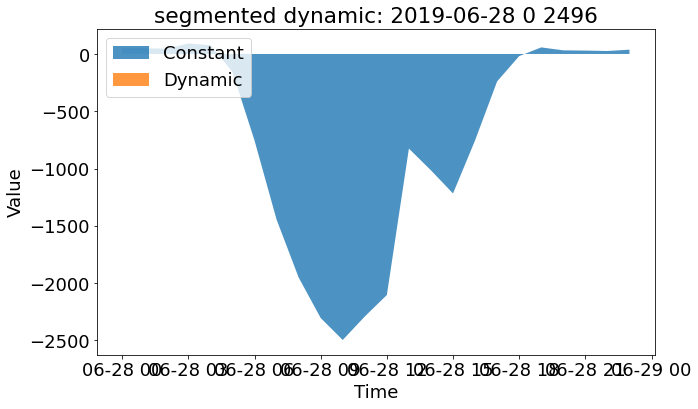

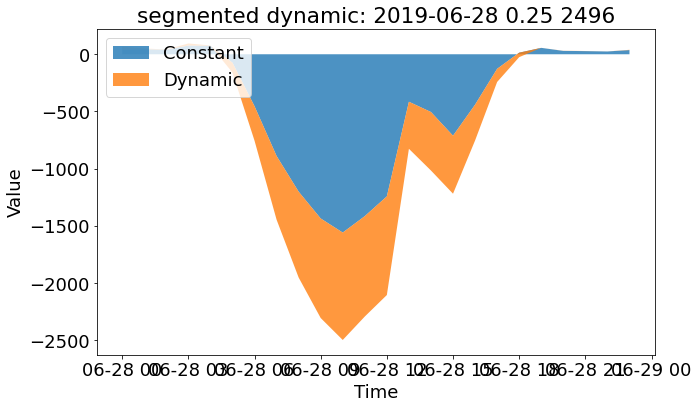

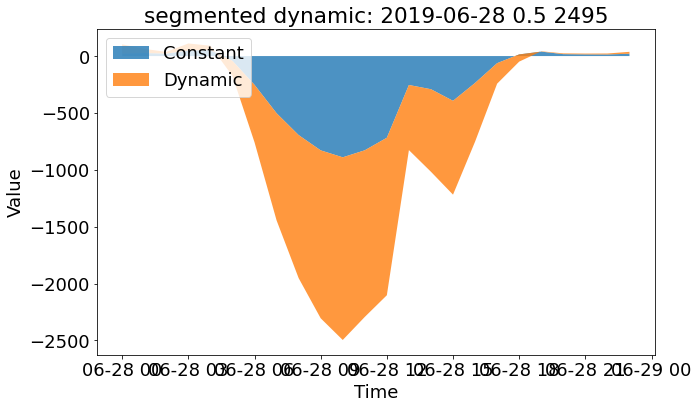

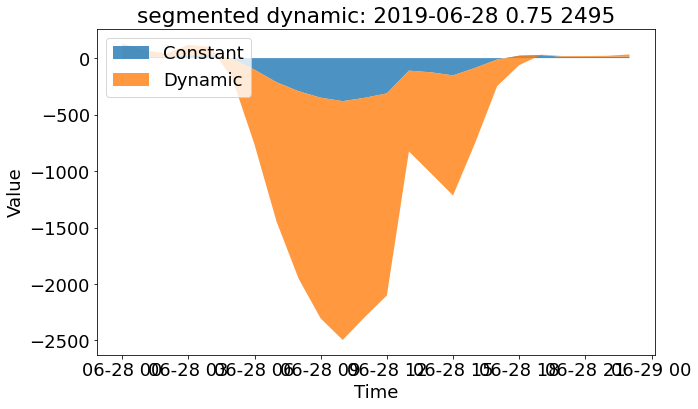

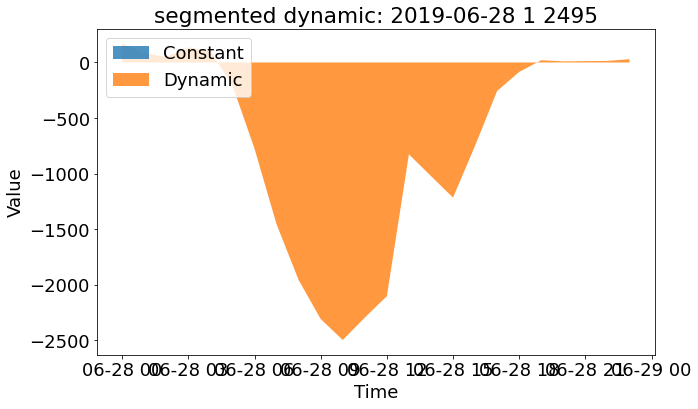

In [18]:
case_amount = int(len(cases) / 2)  # We divide by 2 since we're processing pairs of cases
proliferation_steps = [0, 0.25, 0.5, 0.75, 1]
results = []


for case_idx in range(0, case_amount):
    constant_case_idx = case_idx * 2
    dynamic_case_idx = constant_case_idx + 1
    
    case_constant = cases[constant_case_idx]
    target_df_consumption_constant = settings_to_target_df(case_constant["pricing_type"], case_constant["operation_type"], case_constant["feed_in_tariff"],case_constant["grid_charge_type"],
                                                     case_constant["grid_charging_allowed"])
    case_dynamic = cases[dynamic_case_idx]
    target_df_consumption_dynamic = settings_to_target_df(case_dynamic["pricing_type"], case_dynamic["operation_type"], case_dynamic["feed_in_tariff"],case_dynamic["grid_charge_type"],
                                                     case_dynamic["grid_charging_allowed"])
    
    regulatory_title = f'{case_constant["grid_charge_type"]} {case_constant["feed_in_tariff"]}'
    
    case_result = {"case":regulatory_title}
    print(regulatory_title)
    
    ### Now, we build for the different cases ramp-up profiles
    for proliferation_step in proliferation_steps:
        df_step_comparison = pd.DataFrame()
        df_step_comparison.index = target_df_consumption_dynamic.index
        
        share_idx_dynamic = int(proliferation_step*target_df_consumption_dynamic.shape[1])
        
        # get step dfs
        df_const = target_df_consumption_constant.iloc[:, share_idx_dynamic:].sum(axis=1)
        df_dyn = target_df_consumption_dynamic.iloc[:, :share_idx_dynamic].sum(axis=1)
        if df_const.shape[0] < 1:
            df_step_comparison["Constant"] = 0
        else:
            df_step_comparison["Constant"] = df_const.values
        
        if df_dyn.shape[0] < 1:
            df_step_comparison["Dynamic"] = 0
        else: 
            df_step_comparison["Dynamic"] = df_dyn.values
            
        df_step_comparison['Combined'] = df_step_comparison['Constant'] + df_step_comparison['Dynamic']
        day_with_highest_peak = df_step_comparison['Combined'].abs().idxmax().date()
        peak = df_step_comparison['Combined'].abs().max()
        case_result.update({str(proliferation_step):peak})

        # Extract data for this day
        df_day = df_step_comparison[df_step_comparison.index.date == day_with_highest_peak]

        # Drop the 'Combined' column for plotting
        df_day = df_day.drop(columns=['Combined'])

        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.stackplot(df_day.index, df_day['Constant'], df_day['Dynamic'], labels=['Constant', 'Dynamic'], alpha=0.8)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'{regulatory_title}: {day_with_highest_peak} {proliferation_step} {int(peak)}')
        plt.legend(loc='upper left')
        plt.show()

    results.append(case_result)



In [19]:
target_df_consumption_constant = settings_to_target_df(case_constant["pricing_type"], case_constant["operation_type"], case_constant["feed_in_tariff"],case_constant["grid_charge_type"],
                                                 case_constant["grid_charging_allowed"])
case_dynamic = cases[dynamic_case_idx]
target_df_consumption_dynamic = settings_to_target_df(case_dynamic["pricing_type"], case_dynamic["operation_type"], case_dynamic["feed_in_tariff"],case_dynamic["grid_charge_type"],
                                                 case_dynamic["grid_charging_allowed"])

In [20]:
volumetric_df = settings_to_target_df("dynamic","dynamic","fit","volumetric","false")
segmented_df = settings_to_target_df("dynamic","dynamic","fit","segmented","false")

In [21]:
compare = pd.DataFrame()
compare["Volumetric"] = volumetric_df.sum(axis=1)
compare["Segmented"] = segmented_df.sum(axis=1)

<Axes: >

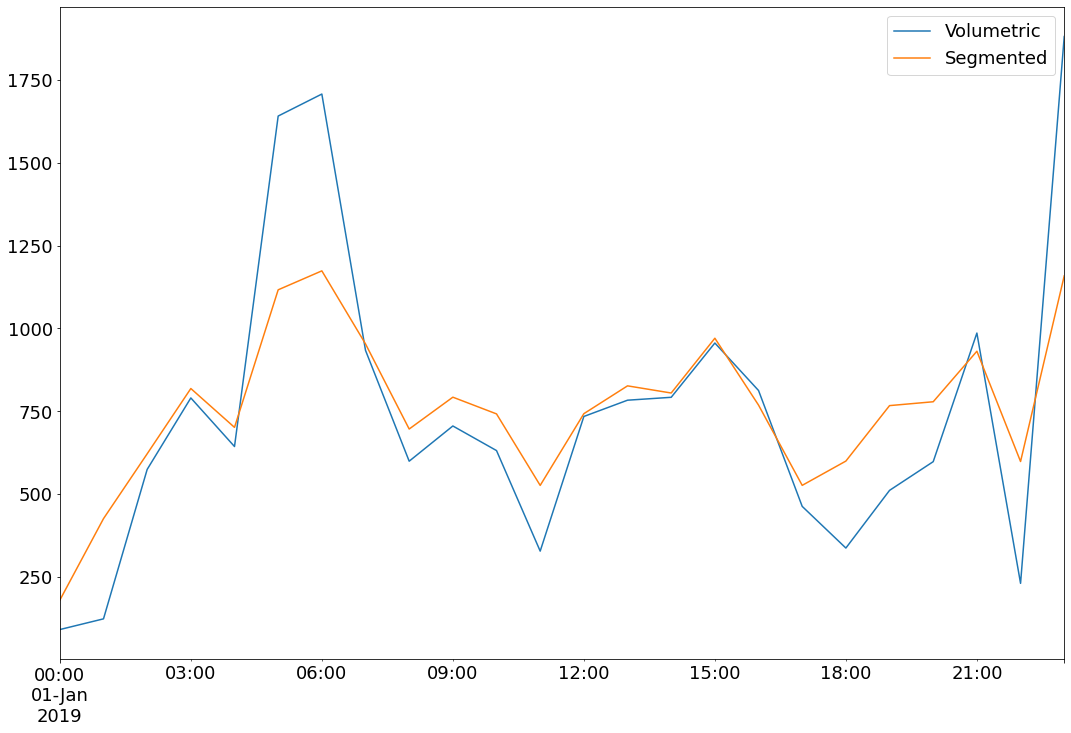

In [22]:
compare.iloc[:24].plot()

<Axes: >

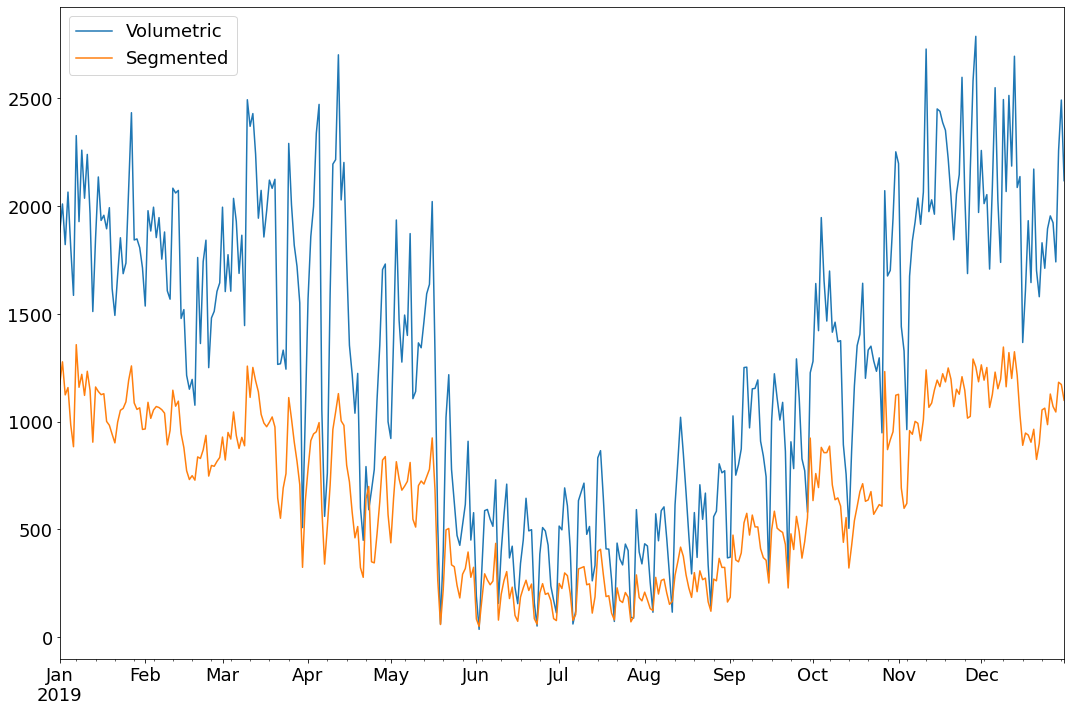

In [23]:
compare.resample("D").max().plot()

In [24]:
compare["Volumetric"].idxmin()

Timestamp('2019-06-28 11:00:00+0000', tz='UTC')

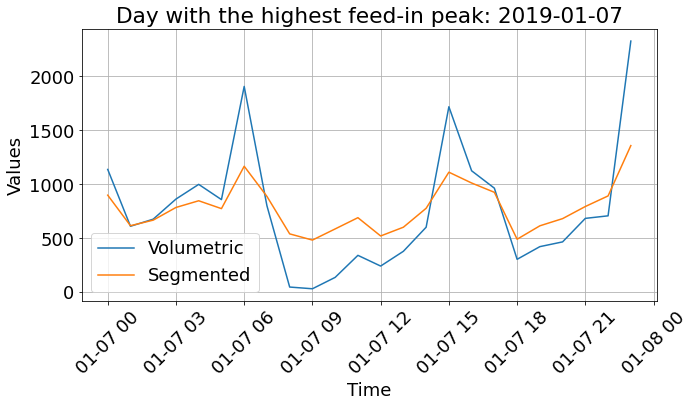

In [25]:
# Find the day with the minimum value in the dataframe
min_day = compare.idxmax().min().date()

# Filter the dataframe to include only that day
day_data = compare.loc[min_day.strftime('%Y-%m-%d')]

# Plot the data for that day
plt.figure(figsize=(10, 6))
plt.plot(day_data.index, day_data["Volumetric"], label='Volumetric')
plt.plot(day_data.index, day_data["Segmented"], label='Segmented')
plt.title(f'Day with the highest feed-in peak: {min_day}')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()